<a href="https://colab.research.google.com/github/rht6226/DL/blob/main/Opportunity2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

In [ ]:
class OpportunityDataset:
    def __init__(self, filepath):
        with np.load(filepath + 'training.npz') as data:
            self.trainX = data['X']
            
            self.trainy = to_categorical(data['y']-1)
            
        with np.load(filepath + 'test.npz') as data:
            self.testX = data['X']
            self.testy = to_categorical(data['y']-1)

        with open(filepath + 'classes.json') as classes:
            self.labels=json.load(classes)

        self.trainX = self.trainX.reshape((self.trainX.shape[0], self.trainX.shape[1], 1))
        self.testX = self.testX.reshape((self.testX.shape[0], self.testX.shape[1], 1))
    
    def summary(self):
        print("Opportunity Human Activity Recognition Dataset: ")
        print("Shape of training data = X:{}, y: {}".format(self.trainX.shape, self.trainy.shape))
        print("Shape of testing data = X:{}, y: {}".format(self.testX.shape, self.testy.shape))
        # print("Shape of validation data = X:{}, y: {}".format(self.validateX.shape, self.validatey.shape))
        print("Number of available labels for classification : {}".format(len(self.labels)))

In [ ]:
opp = OpportunityDataset(filepath='/content/drive/My Drive/HAR Processed Data/Opportunity2/')
opp.summary()

Opportunity Human Activity Recognition Dataset: 
Shape of training data = X:(165465, 242, 1), y: (165465, 18)
Shape of testing data = X:(64092, 242, 1), y: (64092, 18)
Number of available labels for classification : 18


In [ ]:
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, Dropout, concatenate
from keras.utils.vis_utils import plot_model

In [ ]:
def Inception1D(input_layer, filter):
    # 1x1 Convolution
    conv_1x1 = Conv1D(filters=filter[0], kernel_size=1, activation='relu', padding='same')(input_layer)
    # 1x3 Convolution
    conv_1x3_reduce = Conv1D(filters=filter[1][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x3 = Conv1D(filters=filter[1][1], kernel_size=3, activation='relu', padding='same')(conv_1x3_reduce)
    # 1x5 Convolution
    conv_1x5_reduce = Conv1D(filters=filter[2][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x5 = Conv1D(filters=filter[2][1], kernel_size=5, activation='relu', padding='same')(conv_1x5_reduce)
    # 1x3 MaxPooling
    max_1x3 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_layer)
    max_conv_1x1 = Conv1D(filters=filter[3], kernel_size=1, activation='relu', padding='same')(max_1x3)
    # Concat
    output = Concatenate()([conv_1x1, conv_1x3, conv_1x5, max_conv_1x1])
    
    
    return output

In [ ]:
input_shape = (opp.trainX.shape[1], 1)
output_shape = opp.trainy.shape[1]

In [ ]:
def get_inception_model(input_shape, output_shape):
    ip_layer = Input(shape=input_shape)
    x = Inception1D(input_layer=ip_layer, filter=[24, (16, 36), (16, 28), 18])
    x = Inception1D(input_layer=x, filter=[36, (24, 48), (16, 36), 24])
    x = Inception1D(input_layer=x, filter=[32, (12, 32), (16, 48), 36])
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Inception1D(x, [32, (16, 42), (18, 54), 24])
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    
    x = Dense(output_shape, activation='softmax', 
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
              bias_regularizer=regularizers.l2(1e-4), 
              activity_regularizer=regularizers.l2(1e-5))(x)

    model = Model(ip_layer, x, name='inception_HAR')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
model = get_inception_model(input_shape, output_shape)
model.summary()

Model: "inception_HAR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 242, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_193 (Conv1D)             (None, 242, 16)      32          input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_195 (Conv1D)             (None, 242, 16)      32          input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_48 (MaxPooling1D) (None, 242, 1)       0           input_9[0][0]                    
______________________________________________________________________________________

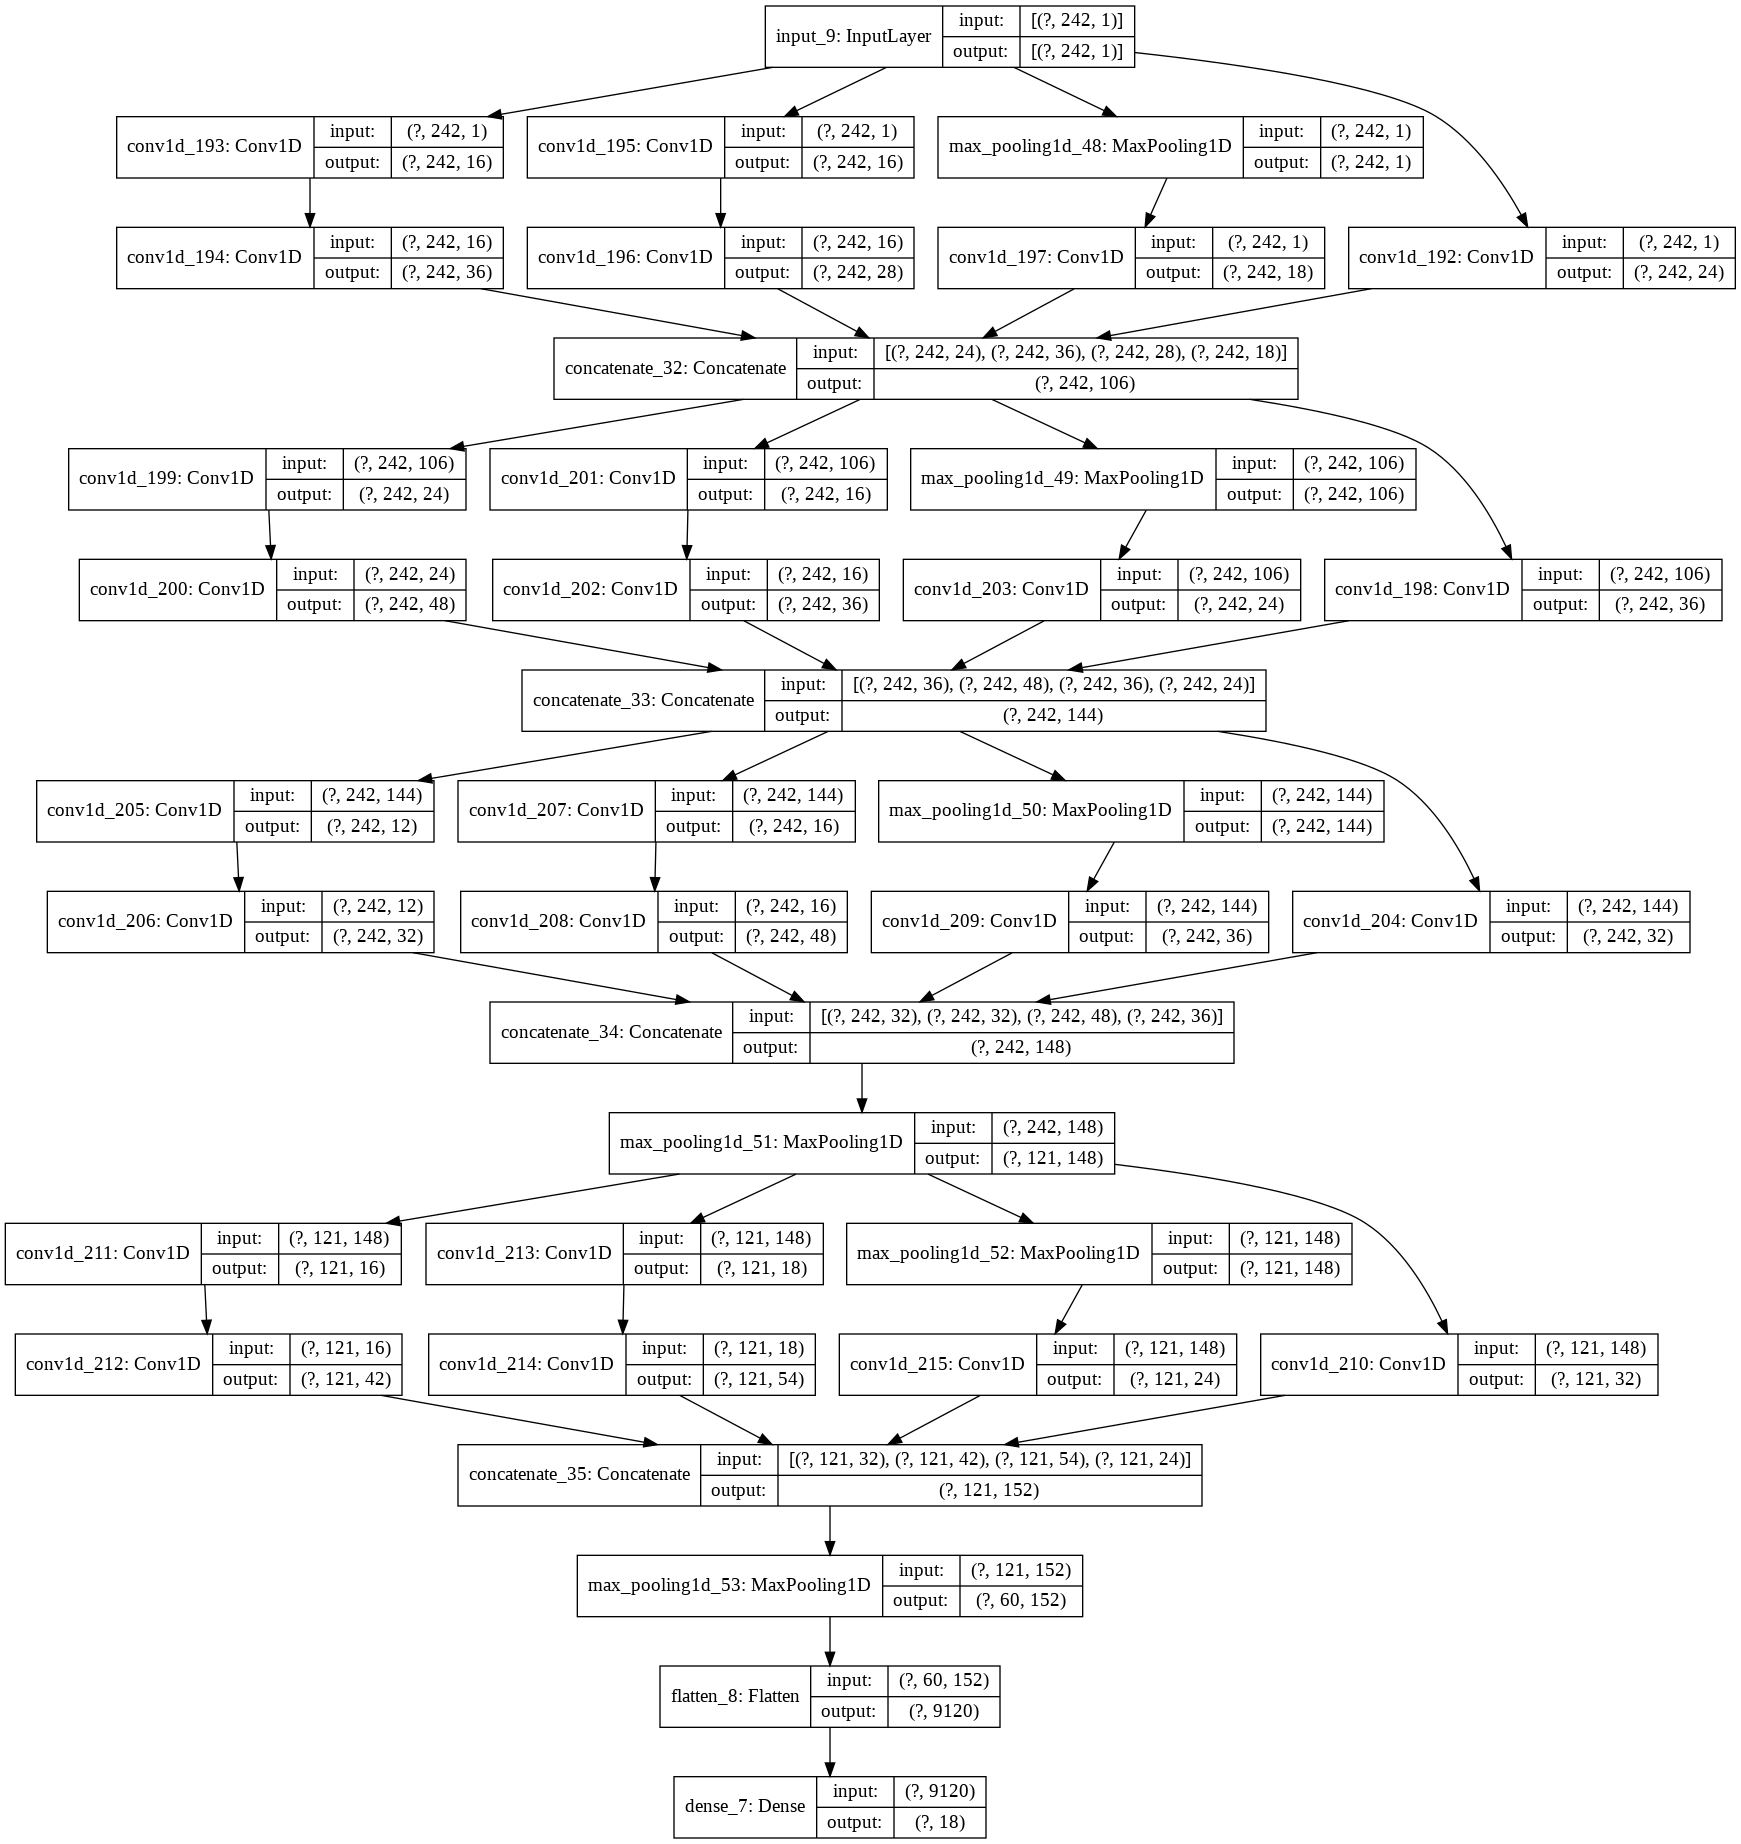

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False)

In [ ]:
history = model.fit(x=opp.trainX, y=opp.trainy, validation_data=(opp.testX, opp.testy), verbose=1, batch_size=32, epochs=8)

Epoch 1/8
5171/5171 [==============================] - 1063s 206ms/step - loss: 0.3276 - accuracy: 0.9126 - val_loss: 0.7962 - val_accuracy: 0.8617
Epoch 2/8
5171/5171 [==============================] - 1042s 202ms/step - loss: 0.1714 - accuracy: 0.9624 - val_loss: 0.8073 - val_accuracy: 0.8251
Epoch 3/8
5171/5171 [==============================] - 1097s 212ms/step - loss: 0.1447 - accuracy: 0.9700 - val_loss: 0.9257 - val_accuracy: 0.8642
Epoch 4/8
5171/5171 [==============================] - 1095s 212ms/step - loss: 0.1281 - accuracy: 0.9747 - val_loss: 0.9413 - val_accuracy: 0.8604
Epoch 5/8
5171/5171 [==============================] - 1080s 209ms/step - loss: 0.1204 - accuracy: 0.9768 - val_loss: 0.8822 - val_accuracy: 0.8567
Epoch 6/8
5171/5171 [==============================] - 1111s 215ms/step - loss: 0.1121 - accuracy: 0.9787 - val_loss: 1.0049 - val_accuracy: 0.8584
Epoch 7/8
5171/5171 [==============================] - 1079s 209ms/step - loss: 0.1057 - accuracy: 0.9804 - val_

In [ ]:
_, accuracy = model.evaluate(opp.testX, opp.testy, batch_size=32, verbose=1)
print(accuracy)

2003/2003 [==============================] - 72s 36ms/step - loss: 0.9590 - accuracy: 0.8585
0.8584534525871277


In [ ]:
# Plotting Loss and Accuracy

import matplotlib.pyplot as plt

def plot_model_accuracy(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for {}'.format(details))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_model_loss(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss for {}'.format(details))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

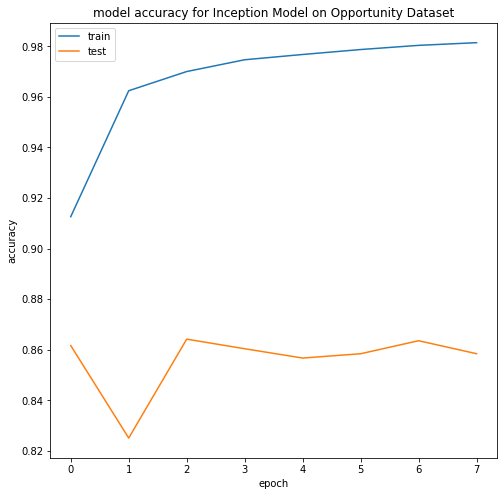

In [ ]:
plot_model_accuracy("Inception Model on Opportunity Dataset", history=history)

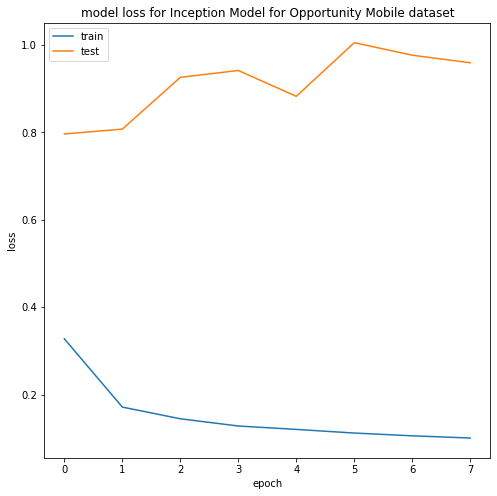

In [ ]:
plot_model_loss("Inception Model for Opportunity Mobile dataset", history=history)

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
def plot_cm(predictedY, testy, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figureSize=[10, 10]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    # Predict Y, And get Confusion Matrix
    predictedY = np.argmax(predictedY, axis = 1)
    testy = np.argmax(testy, axis=1)
    cm = confusion_matrix(y_true=testy, y_pred=predictedY)

    # Plotting
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


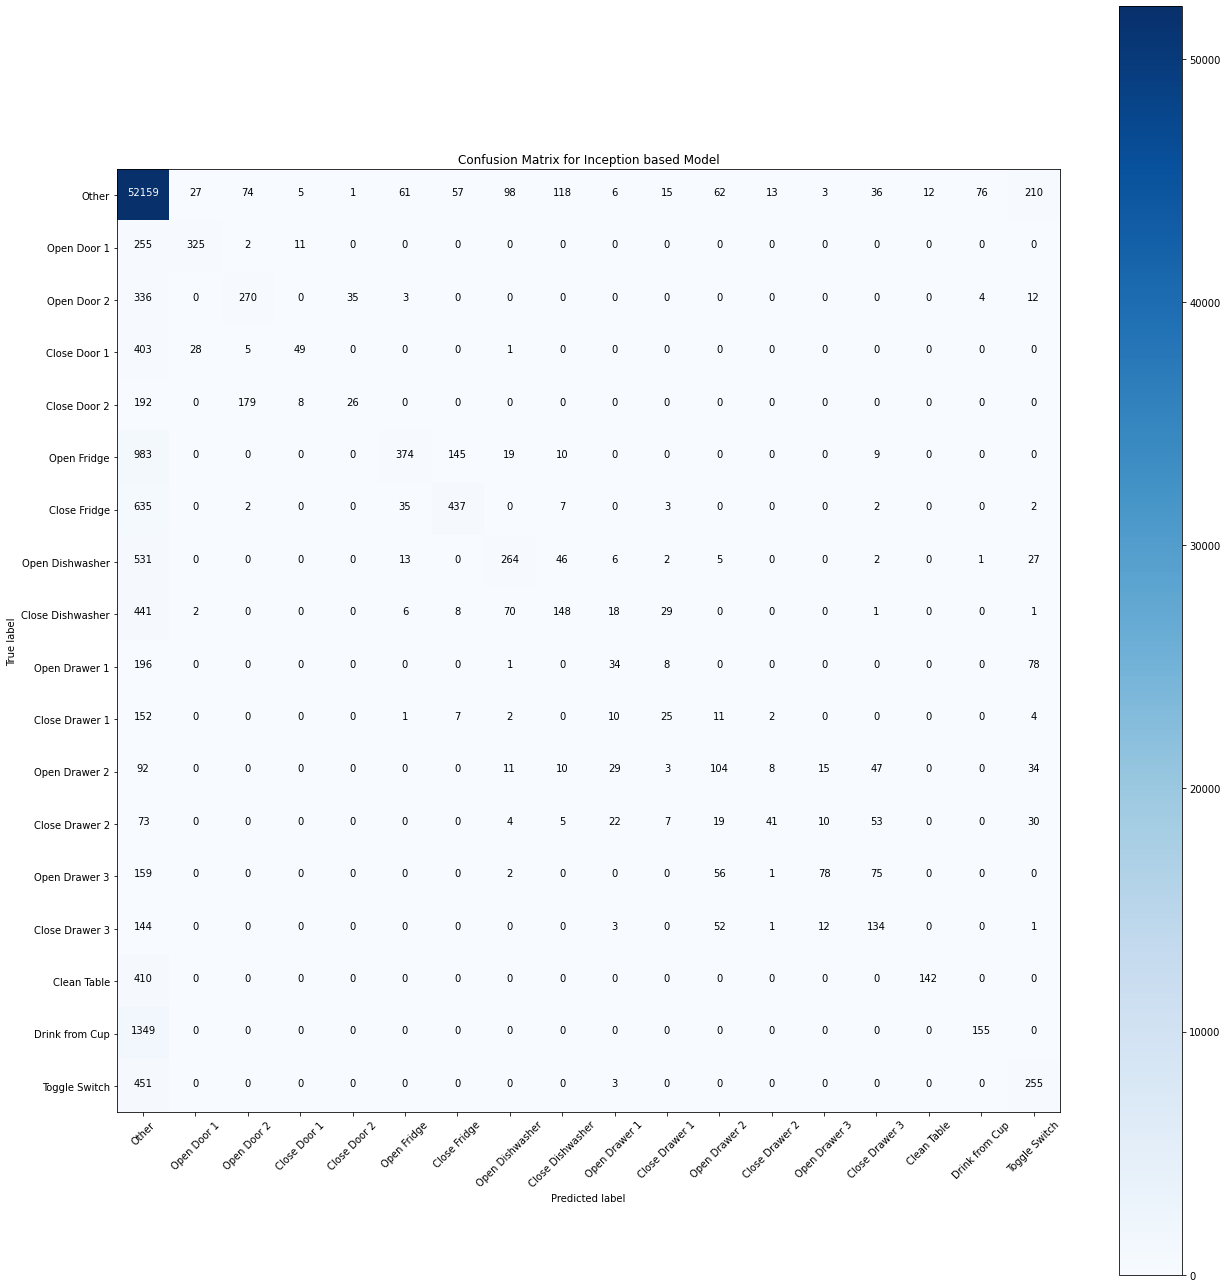

In [ ]:
# CNN Based Network
predictedY = model.predict(opp.testX)
cm_plot_labels = opp.labels
plot_cm(predictedY, testy=opp.testy, classes=cm_plot_labels, title='Confusion Matrix for Inception based Model', figureSize=[18, 18])